# ME-NeuralFMU from the Modelica Conference
Tutorial by Johannes Stoljar, Tobias Thummerer

## License
Copyright (c) 2021 Tobias Thummerer, Lars Mikelsons, Johannes Stoljar

Licensed under the MIT license. See [LICENSE](https://github.com/thummeto/FMIFlux.jl/blob/main/LICENSE) file in the project root for details.

## Motivation
This Julia Package is motivated by the application of hybrid modeling. This package enables the user to integrate his simulation model between neural networks (NeuralFMU). For this, the simulation model must be exported as FMU (functional mock-up unit), which corresponds to a widely used standard. The big advantage of hybrid modeling with artificial neural networks is, that the effects that are difficult to model (because they might be unknown) can be easily learned by the neural networks. For this purpose, the NeuralFMU is trained with measurement data containing the unmodeled physical effect. The final product is a simulation model including the orignially unmodeled effects. Another big advantage of the NeuralFMU is that it works with little data, because the FMU already contains the characterisitic functionality of the simulation and only the missing effects are added.

NeuralFMUs do not need to be as easy as in this example. Basically a NeuralFMU can combine different ANN topologies that manipulate any FMU-input (system state, system inputs, time) and any FMU-output (system state derivative, system outputs, other system variables). However, for this example a NeuralFMU topology as shown in the following picture is used.

![NeuralFMU.svg](https://github.com/thummeto/FMIFlux.jl/blob/main/docs/src/examples/pics/NeuralFMU.svg?raw=true)

*NeuralFMU (ME) from* [[1]](#Source).

## Introduction to the example
In this example, simplified modeling of a one-dimensional spring pendulum (without friction) is compared to a model of the same system that includes a nonlinear friction model. The FMU with the simplified model will be named *simpleFMU* in the following and the model with the friction will be named *realFMU*. At the beginning, the actual state of both simulations is shown, whereby clear deviations can be seen in the graphs. In addition, the initial states are changed for both models and these graphs are also contrasted, and the differences can again be clearly seen. The *realFMU* serves as a reference graph. The *simpleFMU* is then integrated into a NeuralFMU architecture and a training of the entire network is performed. After the training the final state is compared again to the *realFMU*. It can be clearly seen that by using the NeuralFMU, learning of the friction process has taken place.  


## Target group
The example is primarily intended for users who work in the field of first principle and/or hybrid modeling and are further interested in hybrid model building. The example wants to show how simple it is to combine FMUs with machine learning and to illustrate the advantages of this approach.


## Other formats
Besides this [Jupyter Notebook](https://github.com/thummeto/FMIFlux.jl/blob/main/example/modelica_conference_2021.ipynb) there is also a [Julia file](https://github.com/thummeto/FMIFlux.jl/blob/main/example/modelica_conference_2021.jl) with the same name, which contains only the code cells. For the documentation there is a [Markdown file](https://github.com/thummeto/FMIFlux.jl/blob/main/docs/src/examples/modelica_conference_2021.md) corresponding to the notebook.  


## Getting started

### Installation prerequisites
|    | Description                       | Command     |  Alternative  |   
|:--- |:---                               |:---        |:---|
|1.  | Enter Package Manager via         |     ]       |     |
|2.  | Install FMI via                   |   add FMI   | add " https://github.com/ThummeTo/FMI.jl "   |
|3.  | Install FMIFlux via               | add FMIFlux | add " https://github.com/ThummeTo/FMIFlux.jl " |
|4.  | Install Flux via                  |  add Flux   |     |
|5.  | Install DifferentialEquations via | add DifferentialEquations |  |
|6.  | Install Plots via                 | add Plots   |     |

## Code section

To run the example, the previously installed packages must be included. 

In [1]:
# imports
using FMI
using FMIFlux
using Flux
using DifferentialEquations: Tsit5
import Plots

After importing the packages, the path to the *Functional Mock-up Units* (FMUs) is set. The exported FMU is a model meeting the *Functional Mock-up Interface* (FMI) Standard. The FMI is a free standard ([fmi-standard.org](http://fmi-standard.org/)) that defines a container and an interface to exchange dynamic models using a combination of XML files, binaries and C code zipped into a single file. 

The object-orientated structure of the *SpringPendulum1D* (*simpleFMU*) can be seen in the following graphic and corresponds to a simple modeling.

![svg](https://github.com/thummeto/FMIFlux.jl/blob/main/docs/src/examples/pics/SpringPendulum1D.svg?raw=true)

In contrast, the model *SpringFrictionPendulum1D* (*realFMU*) is somewhat more accurate, because it includes a friction component. 

![svg](https://github.com/thummeto/FMIFlux.jl/blob/main/docs/src/examples/pics/SpringFrictionPendulum1D.svg?raw=true)

Here the path for the [*SpringPendulum1D*](https://github.com/thummeto/FMIFlux.jl/blob/main/model/SpringPendulum1D.fmu) and the [*SpringFrictionPendulum1D*](https://github.com/thummeto/FMIFlux.jl/blob/main/model/SpringFrictionPendulum1D.fmu) model is set: 


In [2]:
simpleFMUPath = joinpath(dirname(@__FILE__), "../model/SpringPendulum1D.fmu")
realFMUPath = joinpath(dirname(@__FILE__), "../model/SpringFrictionPendulum1D.fmu")
println("SimpleFMU path: ", simpleFMUPath)
println("RealFMU path: ", realFMUPath)

SimpleFMU path: ../model/SpringPendulum1D.fmu
RealFMU path: ../model/SpringFrictionPendulum1D.fmu


Next, the start time and end time of the simulation are set. Finally, a step size is specified to store the results of the simulation at these time steps.

In [3]:
tStart = 0.0
tStep = 0.01
tStop = 4.0
tSave = collect(tStart:tStep:tStop)

401-element Vector{Float64}:
 0.0
 0.01
 0.02
 0.03
 0.04
 0.05
 0.06
 0.07
 0.08
 0.09
 0.1
 0.11
 0.12
 ⋮
 3.89
 3.9
 3.91
 3.92
 3.93
 3.94
 3.95
 3.96
 3.97
 3.98
 3.99
 4.0

### RealFMU

In the next lines of code the FMU of the *realFMU* model is loaded and instantiated.  

In [4]:
realFMU = fmiLoad(realFMUPath)
fmiInstantiate!(realFMU; loggingOn=false)
fmiInfo(realFMU)

┌ Info: fmi2Unzip(...): Successfully unzipped 28 files at `C:\Users\JOHANN~1\AppData\Local\Temp\fmijl_DBHK6a\SpringFrictionPendulum1D`.
└ @ FMI C:\Users\Johannes Stoljar\.julia\packages\FMI\l4qPg\src\FMI2.jl:273
┌ Info: fmi2Load(...): FMU supports both CS and ME, using CS as default if nothing specified.
└ @ FMI C:\Users\Johannes Stoljar\.julia\packages\FMI\l4qPg\src\FMI2.jl:376
┌ Info: fmi2Load(...): FMU resources location is `file:///C:/Users/JOHANN~1/AppData/Local/Temp/fmijl_DBHK6a/SpringFrictionPendulum1D/resources`
└ @ FMI C:\Users\Johannes Stoljar\.julia\packages\FMI\l4qPg\src\FMI2.jl:384


#################### Begin information for FMU ####################
	Model name:			SpringFrictionPendulum1D
	FMI-Version:			2.0
	GUID:				{b02421b8-652a-4d48-9ffc-c2b223aa1b94}
	Generation tool:		Dymola Version 2020x (64-bit), 2019-10-10
	Generation time:		2021-11-23T13:36:30Z
	Var. naming conv.:		structured
	Event indicators:		24
	Inputs:				0
	Outputs:			0
	States:				2
		33554432 ["mass.s"]
		33554433 ["mass.v", "mass.v_relfric"]
	Supports Co-Simulation:		true
		Model identifier:	SpringFrictionPendulum1D
		Get/Set State:		true
		Serialize State:	true
		Dir. Derivatives:	true
		Var. com. steps:	true
		Input interpol.:	true
		Max order out. der.:	1
	Supports Model-Exchange:	true
		Model identifier:	SpringFrictionPendulum1D
		Get/Set State:		true
		Serialize State:	true
		Dir. Derivatives:	true
##################### End information for FMU #####################


In the following two subsections, the *realFMU* is simulated twice with different initial states to show what effect the choice of initial states has.

#### Default initial states

The FMU is reset to the defined state by the function `fmiReset()`. Then the start and end time are set via the `fmiSetupExperiment()` function. In the next steps the initial states are set. The first state is the position of the mass, which is initilized with $0.5m$, the second state is the velocity, which is initialized with $0\frac{m}{s}$.   

In [5]:
fmiReset(realFMU)
fmiSetupExperiment(realFMU, tStart, tStop)
states = ["s0", "v0"]
x₀ = [0.5, 0.0]

fmiSetReal(realFMU, states, x₀)
fmiEnterInitializationMode(realFMU)
fmiExitInitializationMode(realFMU);

In the following code block the *realFMU* is simulated, still specifying which variables are included. After the simulation is finished the result of the *realFMU* can be plotted. This plot also serves as a reference for the other model (*simpleFMU*). The extracted data will still be needed later on.

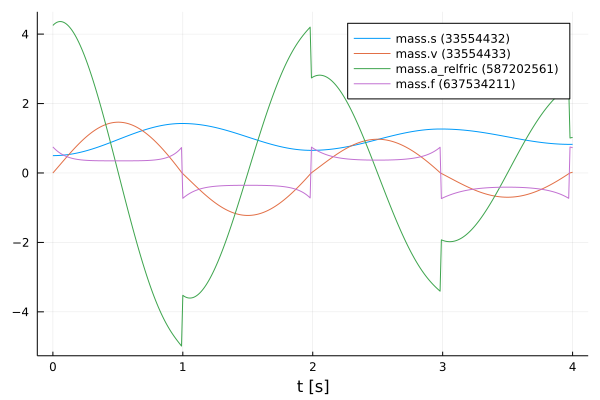

In [6]:
vrs = ["mass.s", "mass.v", "mass.a", "mass.f"]
success, realSimData = fmiSimulate(realFMU, tStart, tStop; recordValues=vrs, saveat=tSave, setup=false, reset=false)
posReal = collect(data[1] for data in realSimData.saveval)
velReal = collect(data[2] for data in realSimData.saveval)
fmiPlot(realFMU, vrs, realSimData)

#### Define functions

The structure of the previous code section is used more often in the further sections, so for clarity the previously explained code sections for resetting, initializing and simulating are combined into one function `simulate()`.

In [7]:
function simulate(FMU, states, x₀, variables, tStart, tStop, tSave)
    fmiReset(FMU)
    fmiSetupExperiment(FMU, tStart, tStop)

    fmiSetReal(FMU, states, x₀)
    fmiEnterInitializationMode(FMU)
    fmiExitInitializationMode(FMU)


    success, simData = fmiSimulate(FMU, tStart, tStop; recordValues=variables, saveat=tSave, setup=false, reset=false)
    return simData
end

simulate (generic function with 1 method)

Also, a function to extract the position and velocity from the simulation data is created.

In [8]:
function extractPosVel(simData)
    posData = collect(data[1] for data in simData)
    velData = collect(data[2] for data in simData)
    return posData, velData
end

extractPosVel (generic function with 1 method)

#### Modified initial states

In contrast to the previous section, other initial states are selected. The position of the mass is initilized with $1.0m$ and the velocity is initialized with $-1.5\frac{m}{s}$. With the modified initial states the *realFMU* is simulated and a graph is generated.

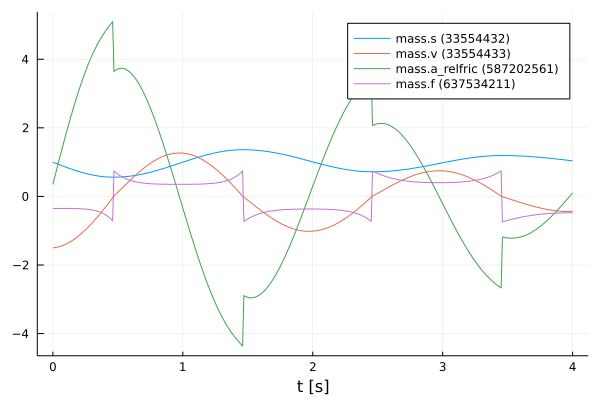

In [9]:
xMod₀ = [1.0, -1.5]
realSimDataMod = simulate(realFMU, states, xMod₀, vrs, tStart, tStop, tSave)
fmiPlot(realFMU, vrs, realSimDataMod)

 After the plots are created, the FMU is unloaded.

In [10]:
fmiUnload(realFMU)

### SimpleFMU

The following lines load and instantiate the *simpleFMU*. 

In [11]:
simpleFMU = fmiLoad(simpleFMUPath)
fmiInstantiate!(simpleFMU; loggingOn=false)
fmiInfo(simpleFMU)

┌ Info: fmi2Unzip(...): Successfully unzipped 28 files at `C:\Users\JOHANN~1\AppData\Local\Temp\fmijl_VQfCmt\SpringPendulum1D`.
└ @ FMI C:\Users\Johannes Stoljar\.julia\packages\FMI\l4qPg\src\FMI2.jl:273


#################### Begin information for FMU ####################
	Model name:			SpringPendulum1D
	FMI-Version:			2.0
	GUID:				{5030e5a4-87c0-42cf-8779-74ebea1906aa}
	Generation tool:		Dymola Version 2020x (64-bit), 2019-10-10
	Generation time:		2021-07-21T05:28:53Z
	Var. naming conv.:		structured
	Event indicators:		0
	Inputs:				0
	Outputs:			0
	States:				2
		33554432 ["mass.s"]
		33554433 ["mass.v"]
	Supports Co-Simulation:		true
		Model identifier:	SpringPendulum1D
		Get/Set State:		true
		Serialize State:	true
		Dir. Derivatives:	true
		Var. com. steps:	true
		Input interpol.:	true
		Max order out. der.:	1
	Supports Model-Exchange:	true
		Model identifier:	SpringPendulum1D
		Get/Set State:		true
		Serialize State:	true
		Dir. Derivatives:	true
##################### End information for FMU #####################


┌ Info: fmi2Load(...): FMU supports both CS and ME, using CS as default if nothing specified.
└ @ FMI C:\Users\Johannes Stoljar\.julia\packages\FMI\l4qPg\src\FMI2.jl:376
┌ Info: fmi2Load(...): FMU resources location is `file:///C:/Users/JOHANN~1/AppData/Local/Temp/fmijl_VQfCmt/SpringPendulum1D/resources`
└ @ FMI C:\Users\Johannes Stoljar\.julia\packages\FMI\l4qPg\src\FMI2.jl:384


The differences between both systems can be clearly seen from the plots in the subchapters. In the plot for the *realFMU* it can be seen that the oscillation continues to decrease due to the effect of the friction. If you would simulate long enough, the oscillation would come to a standstill in a certain time. The oscillation in the *simpleFMU* behaves differently, since the friction was not taken into account here. The oscillation in this model would continue to infinity with the same oscillation amplitude. From this observation the desire of an improvement of this model arises.     


In the following two subsections, the *simpleFMU* is simulated twice with different initial states to show what effect the choice of initial states has.

#### Default initial states

Similar to the simulation of the *realFMU*, the *simpleFMU* is also simulated with the default values for the position and velocity of the mass and then plotted. There is one difference, however, as another state representing a fixed displacement is set. In addition, the last variable is also removed from the varibals to be plotted.

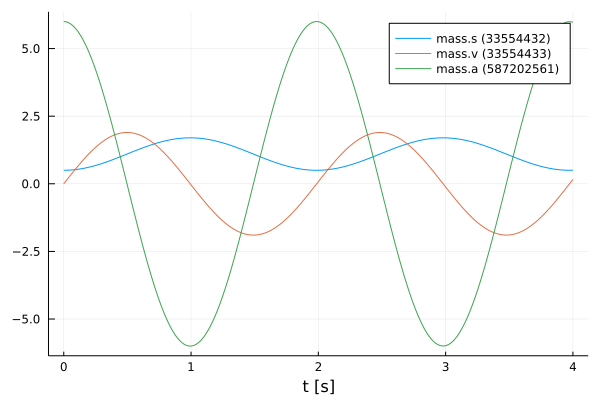

In [12]:
states = ["mass_s0", "mass_v0", "fixed.s0"]
displacement = 0.1
xSimple₀ = vcat(x₀, displacement)
vrs = vrs[1:end-1]

simpleSimData = simulate(simpleFMU, states, xSimple₀, vrs, tStart, tStop, tSave)
fmiPlot(simpleFMU, vrs, simpleSimData)

#### Modified initial states

The same values for the initial states are used for this simulation as for the simulation from the *realFMU* with the modified initial states.

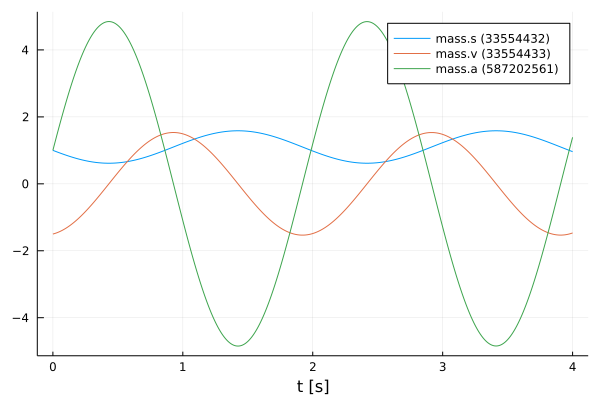

In [13]:
xSimpleMod₀ = vcat(xMod₀, displacement)

simpleSimDataMod = simulate(simpleFMU, states, xSimpleMod₀, vrs, tStart, tStop, tSave)
fmiPlot(simpleFMU, vrs, simpleSimDataMod)

## NeuralFMU

#### Loss function

In order to train our model, a loss function must be implemented. The solver of the NeuralFMU can calculate the gradient of the loss function. The gradient descent is needed to adjust the weights in the neural network so that the sum of the error is reduced and the model becomes more accurate.

The error function in this implementation consists of the mean of the mean squared erros. The first part of the addition is the deviation of the position and the second part is the deviation of the velocity. The mean squared error (mse) for the position consists from the real position of the *realFMU* simulation (posReal) and the position data of the network (posNet). The mean squared error for the velocity consists of the real velocity of the *realFMU* simualtion (velReal) and the velocity data of the network (velNet).
$$ loss = \frac{1}{2} \Bigl[ \frac{1}{n} \sum\limits_{i=0}^n (posReal[i] - posNet[i])^2 + \frac{1}{n} \sum\limits_{i=0}^n (velReal[i] - velNet[i])^2 \Bigr]$$

In [14]:
# loss function for training
function lossSum()
    global x₀
    solution = neuralFMU(x₀)

    posNet, velNet = extractPosVel(solution.u)

    (Flux.Losses.mse(posReal, posNet) + Flux.Losses.mse(velReal, velNet)) / 2.0
end

lossSum (generic function with 1 method)

#### Callback

To output the loss in certain time intervals, a callback is implemented as a function in the following. Here a counter is incremented, every fiftieth pass the loss function is called and the average error is printed out. Also the parmaters for the velocity in the first layer are kept to a fixed value.

In [15]:
# callback function for training
global counter = 0
function callb()
    global counter, paramsNet
    counter += 1

    # freeze first layer parameters (2,4,6) for velocity -> (static) direct feed trough for velocity
    # parameters for position (1,3,5) are learned
    paramsNet[1][2] = 0.0
    paramsNet[1][4] = 1.0
    paramsNet[1][6] = 0.0

    if counter % 50 == 1
        avgLoss = lossSum()
        @info "  Loss [$counter]: $(round(avgLoss, digits=5))
        Avg displacement in data: $(round(sqrt(avgLoss), digits=5))
        Weight/Scale: $(paramsNet[1][1])   Bias/Offset: $(paramsNet[1][5])"
    end
end

callb (generic function with 1 method)

#### Functions for plotting

In this section some important functions for plotting are defined. The function `generate_figure()` creates a new figure object and sets some attributes.

In [16]:
function generate_figure(title, xLabel, yLabel, xlim="auto")
    Plots.plot(
        title=title, xlabel=xLabel, ylabel=yLabel, linewidth=2,
        xtickfontsize=12, ytickfontsize=12, xguidefontsize=12, yguidefontsize=12,
        legendfontsize=12, legend=:topright, xlim=xlim)
end

generate_figure (generic function with 2 methods)

In the following function, the data of the *realFMU*, *simpleFMU* and *neuralFMU* are summarized and displayed in a graph.

In [17]:
function plot_results(title, xLabel, yLabel, interval, realData, simpleData, neuralData)
    linestyles = [:dot, :solid]
    
    fig = generate_figure(title, xLabel, yLabel)
    Plots.plot!(fig, interval, simpleData, label="SimpleFMU", linewidth=2)
    Plots.plot!(fig, interval, realData, label="reference", linewidth=2)
    for i in 1:length(neuralData)
        Plots.plot!(fig, neuralData[i][1], neuralData[i][2], label="NeuralFMU ($(i*2500))", 
                    linewidth=2, linestyle=linestyles[i], linecolor=:green)
    end
    Plots.display(fig)
end

plot_results (generic function with 1 method)

This is the superordinate function, which at the beginning extracts the position and velocity from the simulation data (`realSimData`, `realSimDataMod`, `simpleSimData`,..., `solutionAfterMod`). Four graphs are then generated, each comparing the corresponding data from the *realFMU*, *simpleFMU*, and *neuralFMU*. The comparison is made with the simulation data from the simulation with the default and modified initial states. According to the data, the designation of the title and the naming of the axes is adapted.

In [18]:
function plot_all_results(realSimData, realSimDataMod, simpleSimData, 
        simpleSimDataMod, solutionAfter, solutionAfterMod)    
    # collect all data
    posReal, velReal = extractPosVel(realSimData.saveval)
    posRealMod, velRealMod = extractPosVel(realSimDataMod.saveval)
    posSimple, velSimple = extractPosVel(simpleSimData.saveval)
    posSimpleMod, velSimpleMod = extractPosVel(simpleSimDataMod.saveval)
    
    run = length(solutionAfter)
    
    posNeural, velNeural = [], []
    posNeuralMod, velNeuralMod = [], []
    for i in 1:run
        dataNeural = extractPosVel(solutionAfter[i].u)
        push!(posNeural, (solutionAfter[i].t, dataNeural[1]))
        push!(velNeural, (solutionAfter[i].t, dataNeural[2]))
        
        dataNeuralMod = extractPosVel(solutionAfterMod[i].u)
        push!(posNeuralMod, (solutionAfterMod[i].t, dataNeuralMod[1]))
        push!(velNeuralMod, (solutionAfterMod[i].t, dataNeuralMod[2]))
    end
         
    # plot results s (default initial states)
    xLabel="t [s]"
    yLabel="mass position [m]"
    title = "Default: Mass position after Run: $(run)"
    plot_results(title, xLabel, yLabel, tSave, posReal, posSimple, posNeural)

    # plot results s (modified initial states)
    title = "Modified: Mass position after Run: $(run)"
    plot_results(title, xLabel, yLabel, tSave, posRealMod, posSimpleMod, posNeuralMod)

    # plot results v (default initial states)
    yLabel="mass velocity [m/s]"
    title = "Default: Mass velocity after Run: $(run)"
    plot_results(title, xLabel, yLabel, tSave, velReal, velSimple, velNeural)

    # plot results v (modified initial states)    
    title = "Modified: Mass velocity after Run: $(run)"
    plot_results(title, xLabel, yLabel, tSave, velRealMod, velSimpleMod, velNeuralMod)
end

plot_all_results (generic function with 1 method)

The function `plot_friction_model()` compares the friction model of the *realFMU*, *simpleFMU* and *neuralFMU*. For this, the velocity and force from the simulation data of the *realFMU* is needed. The force data is calculated with the extracted last layer of the *neuralFMU* to the real velocity in line 9 by iterating over the vector `velReal`. In the next rows, the velocity and force data (if available) for each of the three FMUs are combined into a matrix. The first row of the matrix corresponds to the later x-axis and here the velocity is plotted. The second row corresponds to the y-axis and here the force is plotted. This matrix is sorted and plotted by the first entries (velocity) with the function `sortperm()`. The graph with at least three graphs is plotted in line 33. As output this function has the forces of the *neuralFMU*.

In [19]:
function plot_friction_model(realSimData, netBottom, forces)    
    linestyles = [:dot, :solid]
    
    velReal = collect(data[2] for data in realSimData.saveval)
    forceReal = collect(data[4] for data in realSimData.saveval)

    push!(forces, zeros(length(velReal)))
    for i in 1:length(velReal)
        forces[end][i] = -netBottom([velReal[i], 0.0])[2]
    end

    run = length(forces) 
    
    fig = generate_figure("Friction model $(run)", "v [m/s]", "friction force [N]", (-1.25, 1.25))

    fricSimple = hcat(velReal, zeros(length(velReal)))
    fricSimple[sortperm(fricSimple[:, 1]), :]
    Plots.plot!(fig, fricSimple[:,1], fricSimple[:,2], label="SimpleFMU", linewidth=2)

    fricReal = hcat(velReal, forceReal)
    fricReal[sortperm(fricReal[:, 1]), :]
    Plots.plot!(fig, fricReal[:,1], fricReal[:,2], label="reference", linewidth=2)

    for i in 1:run
        fricNeural = hcat(velReal, forces[i])
        fricNeural[sortperm(fricNeural[:, 1]), :]
        Plots.plot!(fig, fricNeural[:,1], fricNeural[:,2], label="NeuralFMU ($(i*2500))", 
                    linewidth=2, linestyle=linestyles[i], linecolor=:green)
        @info "Friction model $i mse: $(Flux.Losses.mse(fricNeural[:,2], fricReal[:,2]))"
    end
    flush(stderr)

    Plots.display(fig)
    
    return forces   
end

plot_friction_model (generic function with 1 method)

The following function is used to display the different displacement modells of the *realFMU*, *simpleFMU* and *neuralFMU*. The displacement of the *realFMU* and *simpleFMU* is very trivial and is only a constant. The position data of the *realFMU* is needed to calculate the displacement. The displacement for the *neuralFMU* is calculated using the first extracted layer of the neural network, subtracting the real position and the displacement of the *simpleFMU*. Also in this function, the graphs of the three FMUs are compared in a plot.

In [20]:
function plot_displacement_model(realSimData, netTop, displacements, tSave, displacement)
    linestyles = [:dot, :solid]
    
    posReal = collect(data[1] for data in realSimData.saveval)
    
    push!(displacements, zeros(length(posReal)))
    for i in 1:length(posReal)
        displacements[end][i] = netTop([posReal[i], 0.0])[1] - posReal[i] - displacement
    end

    run = length(displacements)
    fig = generate_figure("Displacement model $(run)", "t [s]", "displacement [m]")
    Plots.plot!(fig, [tSave[1], tSave[end]], [displacement, displacement], label="simpleFMU", linewidth=2)
    Plots.plot!(fig, [tSave[1], tSave[end]], [0.0, 0.0], label="reference", linewidth=2)
    for i in 1:run
        Plots.plot!(fig, tSave, displacements[i], label="NeuralFMU ($(i*2500))", 
                    linewidth=2, linestyle=linestyles[i], linecolor=:green)
    end

    Plots.display(fig)
    
    return displacements
end

plot_displacement_model (generic function with 1 method)

#### Structure of the NeuralFMU

In the following, the topology of the NeuralFMU is constructed. It consists of a dense layer that has exactly as many inputs and outputs as the model has states `numStates` (and therefore state derivatives). It also sets the initial weights and offsets for the first dense layer, as well as the activation function, which consists of the identity. An input layer follows, which then leads into the *simpleFMU* model. The ME-FMU computes the state derivatives for a given system state. Following the *simpleFMU* is a dense layer that has `numStates` states. The output of this layer consists of 8 output nodes and a *identity* activation function. The next layer has 8 input and output nodes with a *tanh* activation function. The last layer is again a dense layer with 8 input nodes and the number of states as outputs. Here, it is important that no *tanh*-activation function follows, because otherwise the pendulums state values would be limited to the interval $[-1;1]$.

In [21]:
# NeuralFMU setup
numStates = fmiGetNumberOfStates(simpleFMU)

net = Chain(Dense(numStates, numStates, identity; 
                  initW = (out, in) -> [[1.0, 0.0] [0.0, 1.0]], 
                  initb = out -> zeros(out)),
            inputs -> fmi2EvaluateME(simpleFMU, inputs),
            Dense(numStates, 8, identity),
            Dense(8, 8, tanh),
            Dense(8, numStates))

Chain(
  Dense(2, 2),                          # 6 parameters
  var"#17#20"(),
  Dense(2, 8),                          # 24 parameters
  Dense(8, 8, tanh),                    # 72 parameters
  Dense(8, 2),                          # 18 parameters
)                   # Total: 8 arrays, 120 parameters, 1016 bytes.

#### Definition of the NeuralFMU

The instantiation of the ME-NeuralFMU is done as a one-liner. The FMU (*simpleFMU*), the structure of the network `net`, start `tStart` and end time `tStop`, the numerical solver `Tsit5()` and the time steps `tSave` for saving are specified.

In [22]:
neuralFMU = ME_NeuralFMU(simpleFMU, net, (tStart, tStop), Tsit5(); saveat=tSave);

#### Plot before training

Here the state trajactory of the *simpleFMU* is recorded. Doesn't really look like a pendulum yet, but the system is random initialized by default. In the later plots, the effect of learning can be seen.

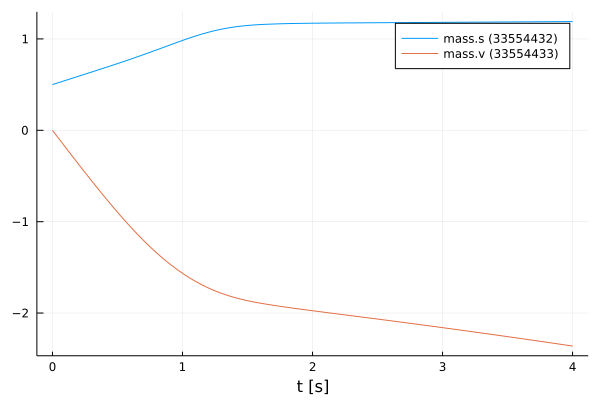

In [23]:
solutionBefore = neuralFMU(x₀)
fmiPlot(simpleFMU, solutionBefore)

#### Training of the NeuralFMU

For the training of the NeuralFMU the parameters are extracted. All parameters of the first layer are set to the absolute value.

In [24]:
# train
paramsNet = Flux.params(neuralFMU)

for i in 1:length(paramsNet[1])
    if paramsNet[1][i] < 0.0 
        paramsNet[1][i] = -paramsNet[1][i]
    end
end

The well-known ADAM optimizer for minimizing the gradient descent is used as further passing parameters. Additionally, the previously defined loss and callback function as well as a one for the number of epochs are passed. Only one epoch is trained so that the NeuralFMU is precompiled.

In [25]:
optim = ADAM()
Flux.train!(lossSum, paramsNet, Iterators.repeated((), 1), optim; cb=callb) 

┌ Info:   Loss [1]: 0.42176
│         Avg displacement in data: 0.64943
│         Weight/Scale: 1.0009999999844448   Bias/Offset: 0.0009999999815963334
└ @ Main In[15]:15


Some vectors for collecting data are initialized and the number of runs, epochs and iterations are set.

In [26]:
solutionAfter = []
solutionAfterMod = []
forces = []
displacements = []

numRuns = 2
numEpochs= 5
numIterations = 500;

#### Training loop

The code section shown here represents the training loop. The loop is structured so that it has `numRuns` runs, where each run has `numEpochs` epochs, and the training is performed at each epoch with `numIterations` iterations. In lines 9 and 10, the data for the *neuralFMU* for the default and modified initial states are appended to the corresponding vectors. The plots for the opposition of position and velocity is done in line 13 by calling the function `plot_all_results`. In the following lines the last layers are extracted from the *neuralFMU* and formed into an independent network `netBottom`. The parmaters for the `netBottom` network come from the original architecture and are shared. In line 20, the new network is used to represent the friction model in a graph. An analogous construction of the next part of the training loop, where here the first layer is taken from the *neuralFMU* and converted to its own network `netTop`. This network is used to record the displacement model. The different graphs are generated for each run and can thus be compared. 

┌ Info: Run: 1/2  Epoch: 1/5
└ @ Main In[27]:3
┌ Info:   Loss [51]: 0.28565
│         Avg displacement in data: 0.53446
│         Weight/Scale: 1.0286111783896719   Bias/Offset: 0.02956336213052823
└ @ Main In[15]:15
┌ Info:   Loss [101]: 0.27637
│         Avg displacement in data: 0.52571
│         Weight/Scale: 1.0227380319341028   Bias/Offset: 0.024779979783415926
└ @ Main In[15]:15
┌ Info:   Loss [151]: 0.23802
│         Avg displacement in data: 0.48787
│         Weight/Scale: 1.0109595043163218   Bias/Offset: 0.017657584767572194
└ @ Main In[15]:15
┌ Info:   Loss [201]: 0.11284
│         Avg displacement in data: 0.33591
│         Weight/Scale: 1.0187168091838543   Bias/Offset: 0.04967643587576684
└ @ Main In[15]:15
┌ Info:   Loss [251]: 0.04202
│         Avg displacement in data: 0.20498
│         Weight/Scale: 1.0513631843151288   Bias/Offset: 0.08709946191489178
└ @ Main In[15]:15
┌ Info:   Loss [301]: 0.03441
│         Avg displacement in data: 0.18549
│         Weight/Scale:

┌ Info:   Loss [2401]: 0.00185
│         Avg displacement in data: 0.04297
│         Weight/Scale: 1.0155961224151784   Bias/Offset: 0.06842376493363168
└ @ Main In[15]:15
┌ Info:   Loss [2451]: 0.0018
│         Avg displacement in data: 0.04241
│         Weight/Scale: 1.0158045051687399   Bias/Offset: 0.06879297485736173
└ @ Main In[15]:15
┌ Info:   Loss [2501]: 0.00175
│         Avg displacement in data: 0.04188
│         Weight/Scale: 1.0160158385445512   Bias/Offset: 0.0691605750753205
└ @ Main In[15]:15


3164.063564 seconds (7.76 G allocations: 476.333 GiB, 4.15% gc time)


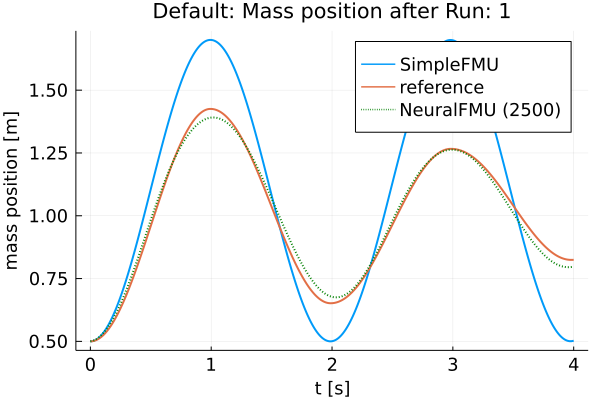

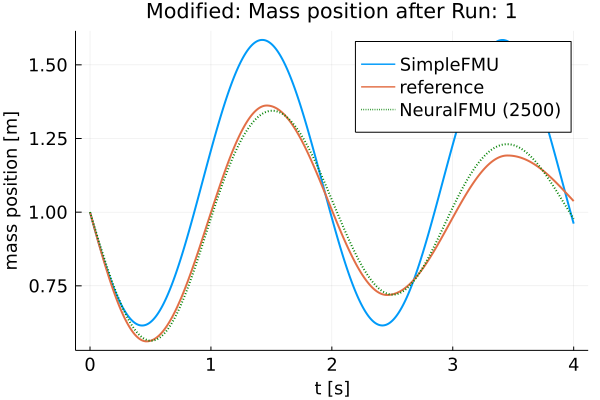

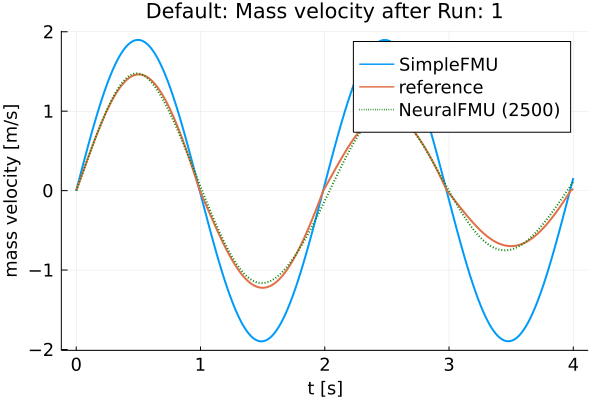

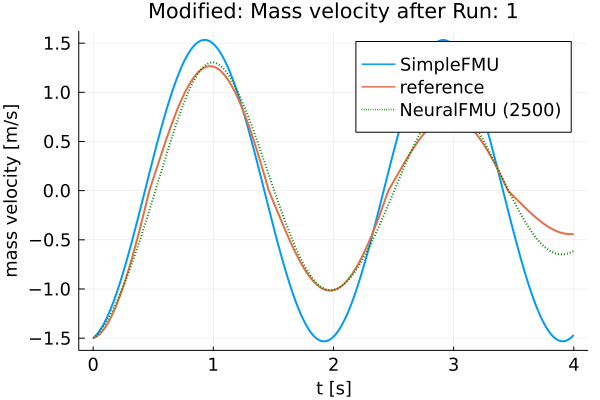

┌ Info: Friction model 1 mse: 0.7541038092408717
└ @ Main In[19]:29


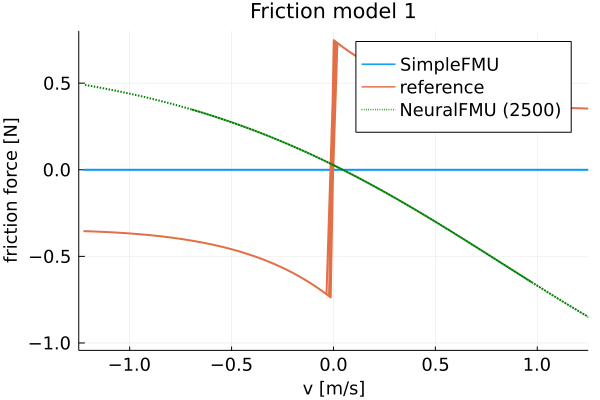

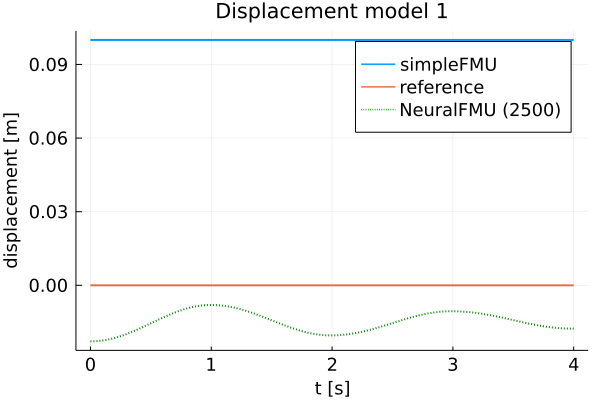

┌ Info: Run: 2/2  Epoch: 1/5
└ @ Main In[27]:3
┌ Info:   Loss [2551]: 0.00171
│         Avg displacement in data: 0.04137
│         Weight/Scale: 1.016229548801126   Bias/Offset: 0.06952624500869685
└ @ Main In[15]:15
┌ Info:   Loss [2601]: 0.00167
│         Avg displacement in data: 0.04088
│         Weight/Scale: 1.0164450811761696   Bias/Offset: 0.06988965411129339
└ @ Main In[15]:15
┌ Info:   Loss [2651]: 0.00163
│         Avg displacement in data: 0.04042
│         Weight/Scale: 1.0166619044860516   Bias/Offset: 0.07025046670690757
└ @ Main In[15]:15
┌ Info:   Loss [2701]: 0.0016
│         Avg displacement in data: 0.03998
│         Weight/Scale: 1.0168795146203686   Bias/Offset: 0.07060834433025422
└ @ Main In[15]:15
┌ Info:   Loss [2751]: 0.00156
│         Avg displacement in data: 0.03955
│         Weight/Scale: 1.0170974387940153   Bias/Offset: 0.07096295141121652
└ @ Main In[15]:15
┌ Info:   Loss [2801]: 0.00153
│         Avg displacement in data: 0.03915
│         Weight/Sca

┌ Info:   Loss [4901]: 0.00089
│         Avg displacement in data: 0.02985
│         Weight/Scale: 1.0194643521872544   Bias/Offset: 0.07784603468403976
└ @ Main In[15]:15
┌ Info:   Loss [4951]: 0.00088
│         Avg displacement in data: 0.02969
│         Weight/Scale: 1.0193938823333755   Bias/Offset: 0.07784323586407052
└ @ Main In[15]:15
┌ Info:   Loss [5001]: 0.00087
│         Avg displacement in data: 0.02953
│         Weight/Scale: 1.0193205792837756   Bias/Offset: 0.07783135347576647
└ @ Main In[15]:15


3141.788865 seconds (7.75 G allocations: 476.097 GiB, 4.18% gc time)


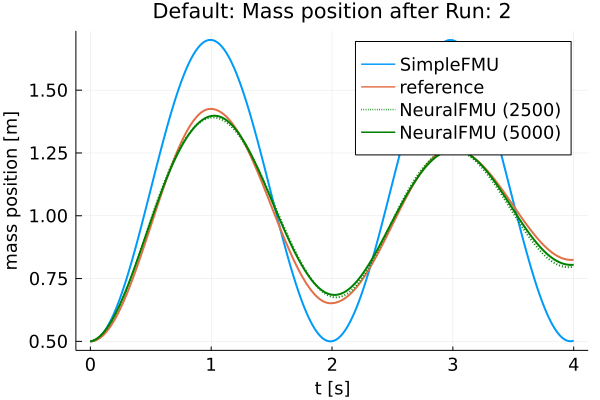

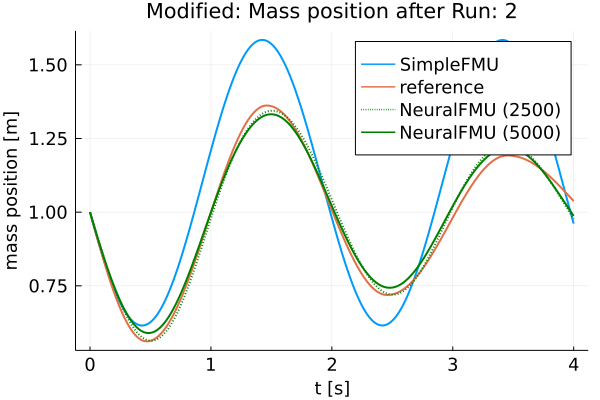

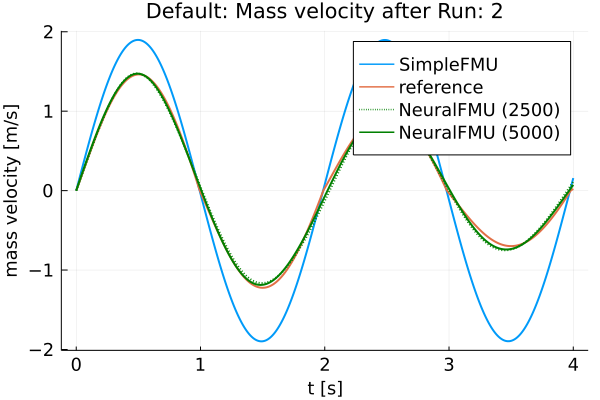

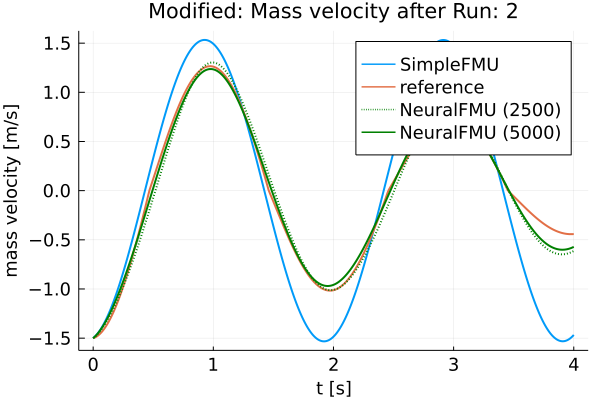

┌ Info: Friction model 1 mse: 0.7541038092408717
└ @ Main In[19]:29
┌ Info: Friction model 2 mse: 0.7459716547805014
└ @ Main In[19]:29


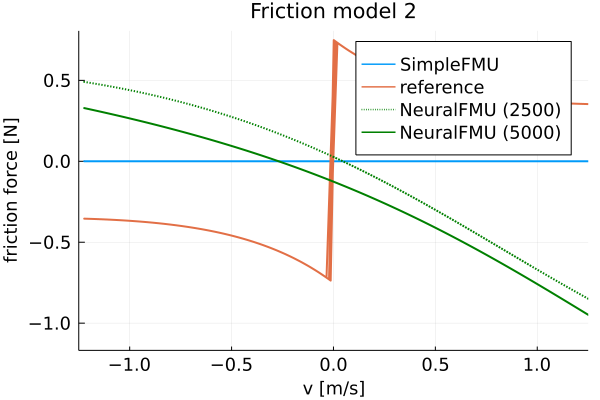

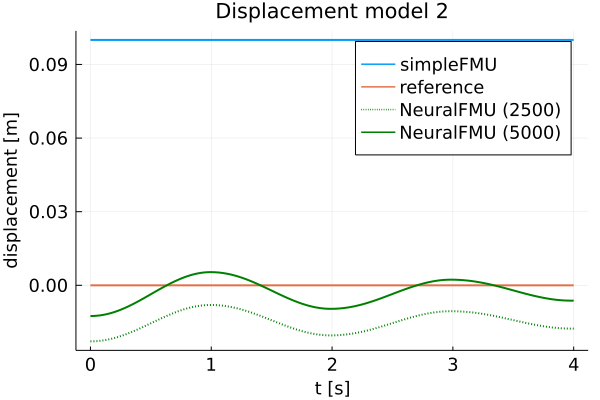

In [27]:
for run in 1:numRuns    
    @time for epoch in 1:numEpochs
        @info "Run: $(run)/$(numRuns)  Epoch: $(epoch)/$(numEpochs)"
        Flux.train!(lossSum, paramsNet, Iterators.repeated((), numIterations), optim; cb=callb)
    end
    flush(stderr)
    flush(stdout)
    
    push!(solutionAfter, neuralFMU(x₀))
    push!(solutionAfterMod, neuralFMU(xMod₀))

    # generate all plots for the position and velocity
    plot_all_results(realSimData, realSimDataMod, simpleSimData, simpleSimDataMod, solutionAfter, solutionAfterMod)
    
    # friction model extraction
    layersBottom = neuralFMU.neuralODE.model.layers[3:5]
    netBottom = Chain(layersBottom...)
    transferParams!(netBottom, paramsNet, 7)
    
    forces = plot_friction_model(realSimData, netBottom, forces) 
    
    # displacement model extraction
    layersTop = neuralFMU.neuralODE.model.layers[1:1]
    netTop = Chain(layersTop...)
    transferParams!(netTop, paramsNet, 1)

    displacements = plot_displacement_model(realSimData, netTop, displacements, tSave, displacement)
end

Finally, the FMU is cleaned-up.

In [28]:
fmiUnload(simpleFMU)

### Summar

Based on the plots, it can be seen that the curves of the *realFMU* and the *neuralFMU* are very close. The *neuralFMU* is able to learn the friction and displacement model.

### Source

[1] Tobias Thummerer, Lars Mikelsons and Josef Kircher. 2021. **NeuralFMU: towards structural integration of FMUs into neural networks.** Martin Sjölund, Lena Buffoni, Adrian Pop and Lennart Ochel (Ed.). Proceedings of 14th Modelica Conference 2021, Linköping, Sweden, September 20-24, 2021. Linköping University Electronic Press, Linköping (Linköping Electronic Conference Proceedings ; 181), 297-306. [DOI: 10.3384/ecp21181297](https://doi.org/10.3384/ecp21181297)
